# Examine a few Predictions for the BA model

In [1]:
# imports
import os
import yaml

import numpy as np
import h5py
import pandas

import torch
from torch.utils.data import Dataset
from torch import nn
from tqdm import tqdm

from matplotlib import pyplot as plt
import seaborn as sns

from pytorch3dunet.unet3d.model import get_model
from pytorch3dunet.unet3d.config import load_config
from pytorch3dunet.unet3d import utils
from pytorch3dunet.unet3d.model import UNet2D
import pytorch3dunet.augment.transforms as transforms
from pytorch3dunet.datasets.utils import calculate_stats

from fronts.plotting import images
from fronts.po import fronts as po_fronts

# Single image DataSet

In [2]:
class ImageDataset(Dataset):
    def __init__(self, raws, transform):
        self.transformer = transform
        self.raw = raws
        self.raw_transform = self.transformer.raw_transform()

    def __len__(self):
        return 1

    def __getitem__(self, global_idx):     
        image = self.raw[global_idx]
        image_transformed = self.raw_transform(image)
        
        return image_transformed

# Needed methods

In [3]:
def _is_2d_model(model):
    if isinstance(model, nn.DataParallel):
        model = model.module
    return isinstance(model, UNet2D)

# Load config

In [4]:
config = yaml.safe_load(open('llc4320_sst144_sss40_trainBA.yml', 'r'))

# Load Model

In [5]:
model = get_model(config['model'])

## Load Model State

In [6]:
#model_path = config['model_path']
#logger.info(f'Loading model from {model_path}...')
_ = utils.load_checkpoint(os.path.join(os.getenv('OS_OGCM'), 'LLC', 'Fronts', 'Models', 'BA', 'best_checkpoint.pytorch'), model)

/home/xavier/Projects/Oceanography/python/pytorch-3dunet/pytorch3dunet/unet3d/utils.py:51: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(checkpoint_path, 

## CPU/GPU

In [7]:
torch.cuda.device_count()

0

In [8]:
if  torch.cuda.device_count() > 0:
    config['device'] = 'gpu'
if torch.cuda.device_count() > 1 and not config['device'] == 'cpu':
    model = nn.DataParallel(model)
    #logger.info(f'Using {torch.cuda.device_count()} GPUs for prediction')
if torch.cuda.is_available() and not config['device'] == 'cpu':
    model = model.cuda()

# Use valid data

In [9]:
valid_file = os.path.join(os.getenv('OS_OGCM'), 'LLC', 'Fronts', 'Training_Sets', 'LLC4320_SST144_SSS40_validB.h5')
valid_tfile = valid_file.replace('h5', 'parquet')
train_file = valid_file.replace('valid', 'train')
train_tfile = valid_tfile.replace('valid', 'train')

In [10]:
valid_tbl = pandas.read_parquet(valid_tfile)
train_tbl = pandas.read_parquet(train_tfile)

In [11]:
#f.close()
f = h5py.File(valid_file,'r')
ft = h5py.File(train_file,'r')

In [54]:
use_valid = False
idx = 5

if use_valid:
    img = f['inputs'][idx:idx+1]
    targ = f['targets'][idx:idx+1]
    targ.sum(), valid_tbl.iloc[idx].UID
else:
    # Training image
    img = ft['inputs'][idx:idx+1]
    targ = ft['targets'][idx:idx+1]
    targ.sum(), train_tbl.iloc[idx].UID

In [55]:
f['inputs'].attrs['UID'][idx]

np.bytes_(b'133345406917442708')

## ImageLoader

In [56]:
transformer_config = config['loaders']['val']['transformer']
stats = calculate_stats(None, True)
transformer = transforms.Transformer(transformer_config, stats)

In [57]:
iDataset = ImageDataset(img, transformer)

In [58]:
test_loader = torch.utils.data.DataLoader(
                    iDataset, batch_size=1,
                    shuffle=False,
                    num_workers=1,
                    pin_memory=False, sampler=None)

# Go for it

In [59]:
_ = model.eval()

In [60]:
with torch.no_grad():
    for input in tqdm(test_loader):
        # send batch to gpu
        if torch.cuda.is_available():
            input = input.pin_memory().cuda(non_blocking=True)

        if _is_2d_model(model):
            # remove the singleton z-dimension from the input
            input = torch.squeeze(input, dim=-3)
            # forward pass
            prediction = model(input)
            # add the singleton z-dimension to the output
            prediction = torch.unsqueeze(prediction, dim=-3)
        else:
            # forward pass
            prediction = model(input)

100%|████████████████████████████████████████████| 1/1 [00:00<00:00,  1.65it/s]


# View it!

<Axes: >

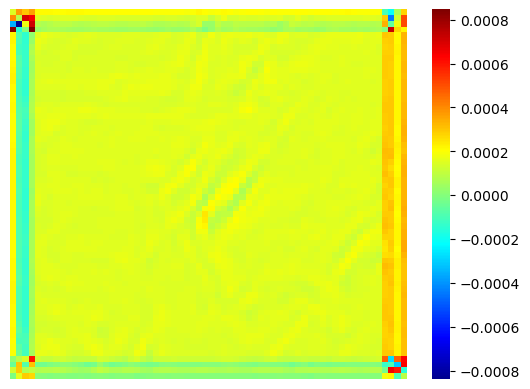

In [61]:
images.show_image(prediction[0,0,0,...].cpu())

<Axes: >

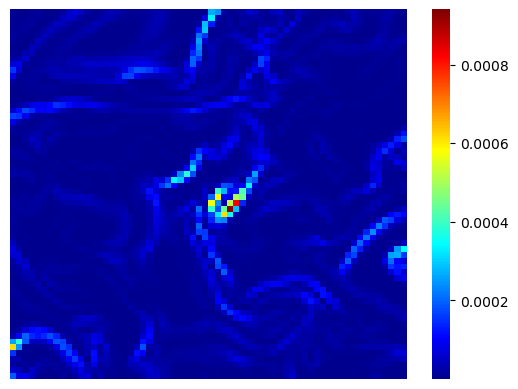

In [62]:
#images.show_image(targ[0,0,0,...])
#images.show_image(np.log10(img[0,0,0,...]))
images.show_image(img[0,0,0,...])

<Axes: >

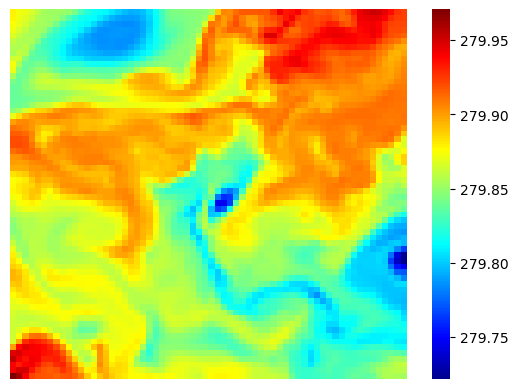

In [63]:
images.show_image(img[0,2,0,...])

<Axes: >

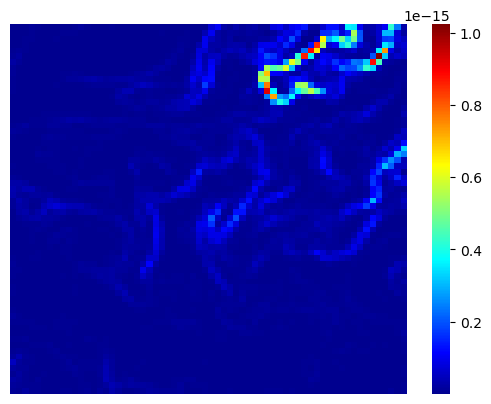

In [64]:
images.show_image(targ[0,0,0,...])
#images.show_image(np.log10(targ[0,0,0,...]))

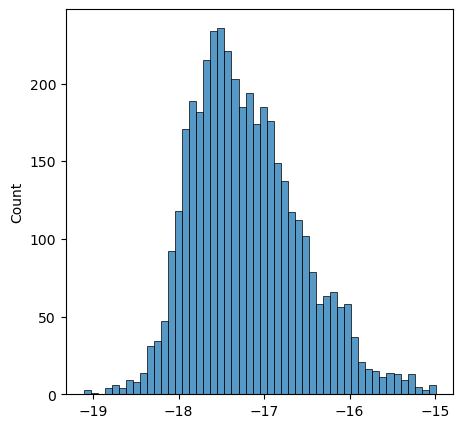

In [65]:
fig = plt.figure(figsize=(5,5))
ax = plt.gca()
#
sns.histplot(np.log10(targ[0,0,0,...]).flatten(), ax=ax, bins=50)
#
plt.show()

In [52]:
targ[0,0,0,...].min()

np.float32(5.685858e-18)

# Actual $|\nabla b^2|$

In [38]:
llc_d = np.load('/home/xavier/Projects/Oceanography/data/OGCM/LLC/Fronts/llc.npz')
list(llc_d.keys())

['SST', 'SSS', 'Divb2']

In [90]:
p05, p90, p95 = np.percentile(llc_d['Divb2'].flatten(), [5,90,95])
p05, p90, p95

(np.float64(4.311967260609761e-16),
 np.float64(1.8115615432278538e-14),
 np.float64(2.98340686008002e-14))

<Axes: >

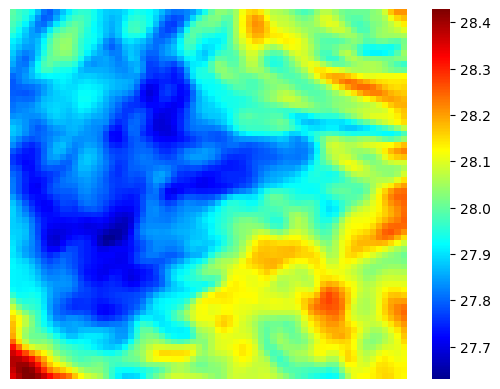

In [91]:
images.show_image(llc_d['SST'])

<Axes: >

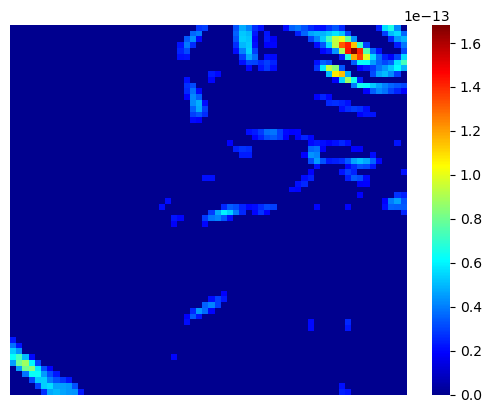

In [94]:
images.show_image(llc_d['Divb2'] * (llc_d['Divb2'] > p90))#, cm='Greys')
#images.show_image(llc_d['SST'])

<Axes: >

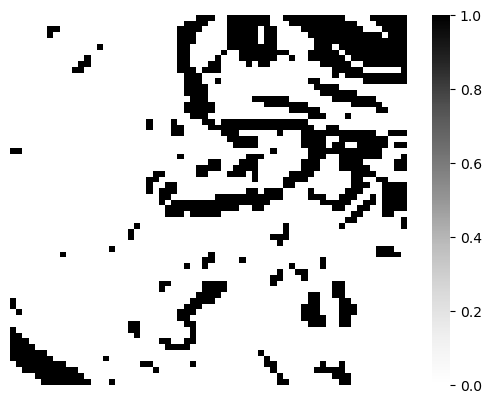

In [93]:
images.show_image(llc_d['Divb2'] > 1e-14, cm='Greys')

In [55]:
llc_d['Divb2'].min()

np.float64(1.2663906629927777e-16)

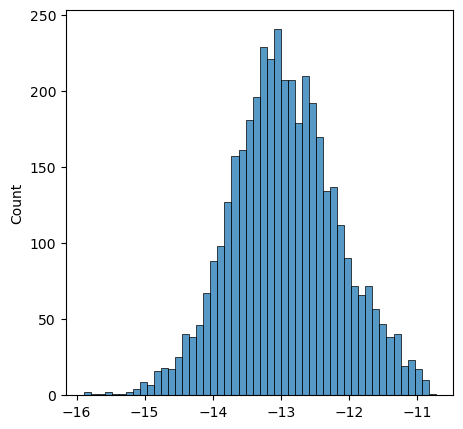

In [60]:
fig = plt.figure(figsize=(5,5))
ax = plt.gca()
#
sns.histplot(np.log10(llc_d['Divb2']).flatten(), ax=ax, bins=50)
#
plt.show()

In [59]:
llc_d['Divb2'].shape

(64, 64)

In [62]:
llc_d['Divb2'].std()

np.float64(1.3947229853101787e-12)